<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Deep Learning School FPMI MIPT</b></h3>

<h3 style="text-align: center;"><b> Autoencoders


# Part 1. Vanilla Autoencoder

## 1.1. Data prepare


In [1]:
import numpy as np
import os
from copy import deepcopy
import wget
import pandas as pd
from tqdm import notebook
import skimage
from PIL import Image
from imageio import imread
import gc
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize((dimx,dimy))))
    
    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [36]:
data, attrs = fetch_dataset()

Let's split the sample of images into trains and vals, print some images to output to see what they look like, and cast the images to pytorch tensors so we can feed them to networks:

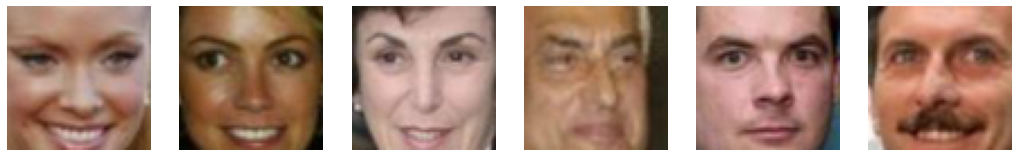

In [37]:
X = data
X = np.float32(X/255.)
X_train, X_val = train_test_split(X, test_size=0.3, random_state=42)

# вывод картинок на экран
plt.figure(figsize=(18,6))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis('off')
    plt.imshow(X_train[i])

batch_size = 5

data_tr = DataLoader(np.rollaxis(X_train, 3, 1), batch_size=batch_size, shuffle=True)
data_val = DataLoader(np.rollaxis(X_val, 3, 1), batch_size=batch_size, shuffle=True)

## 1.2. Model architecture

<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">





In [38]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_layer_1 = nn.Conv2d(3, 128, 3, padding=1)
        self.encoder_layer_2 = nn.Conv2d(128, 1, 3, padding=1)
        self.decoder_layer_1 = nn.Conv2d(1, 128, 3, padding=1)
        self.decoder_layer_2 = nn.Conv2d(128, 3, 3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        x = self.encoder_layer_2(x)
        x = self.relu(x)
        
        return x
    
    def decode(self, z):
        z = self.decoder_layer_1(z)
        z = self.relu(z)
        z = self.decoder_layer_2(z)
        reconstruction = self.sigmoid(z)
        return reconstruction

    def forward(self, x):
        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)
        return reconstruction, latent_code

In [39]:
DEVICE = torch.device('cuda')
criterion = nn.MSELoss()
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

## 1.3 Training

It remains to write the code for learning the autoencoder. In this case, it would be nice to sometimes watch how the autoencoder reconstructs images at this stage of training in the process. For example, after each epoch (running the train sample through the autoeecoder), you can see what reconstructions have been obtained for some images val of the sample.

In [40]:
rng = np.random.default_rng(seed=42)
idx = rng.choice(len(X_val), 5)

def predict_val(x, autoencoder):
    autoencoder.eval()
    with torch.no_grad():
        x = torch.from_numpy(np.rollaxis(x,3,1))   
        x = x.to(DEVICE)   
    reconstruction, latent_code = autoencoder(x)
    x = reconstruction.cpu().detach().numpy()
    x = np.rollaxis(x,1,4)
    return x

In [41]:
def train(val, train, epochs):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch, epochs))
        autoencoder.train()
        avg_loss=0
        for i, X_batch in enumerate(notebook.tqdm(data_tr)):
            X_batch = X_batch.to(DEVICE)
            optimizer.zero_grad()
            reconstruction, latent_code = autoencoder(X_batch)
            loss = criterion(reconstruction, X_batch.detach())
            avg_loss += loss / len(data_tr)
            loss.backward()
            optimizer.step()
        train_loss = avg_loss
        train_losses.append(train_loss.cpu().detach().numpy())
        print(f'train loss {np.round(avg_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')

        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for i, X_batch in enumerate(notebook.tqdm(data_val)):
                X_batch = X_batch.to(DEVICE)
                reconstruction, latent_code = autoencoder(X_batch)
                loss = criterion(reconstruction, X_batch.detach())
                val_loss += loss / len(data_val)
            print(f'val loss {np.round(val_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')
        val_losses.append(val_loss.cpu().detach().numpy())
        x = predict_val(X_val[idx], autoencoder)
        clear_output()

        plt.figure(figsize=(18,6))
        for i in range(5):
            plt.subplot(2, 5, i+1)
            plt.imshow(X_val[idx][i])
            plt.subplot(2, 5, 5+i+1)
            plt.imshow(x[i])
        fig = plt.figure(figsize=(9, 9))
        plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}')
        plt.plot(np.arange(len(val_losses)), val_losses, label=f'Val, loss: {val_loss:.3f}')
        plt.title(f'Epoch {epoch}')
        plt.legend(loc='best')
        plt.show()
    
        torch.cuda.empty_cache()
        gc.collect()
    return autoencoder, latent_code , train_losses, val_losses

Let's see how our trained auto-ecoder encodes and restores pictures:

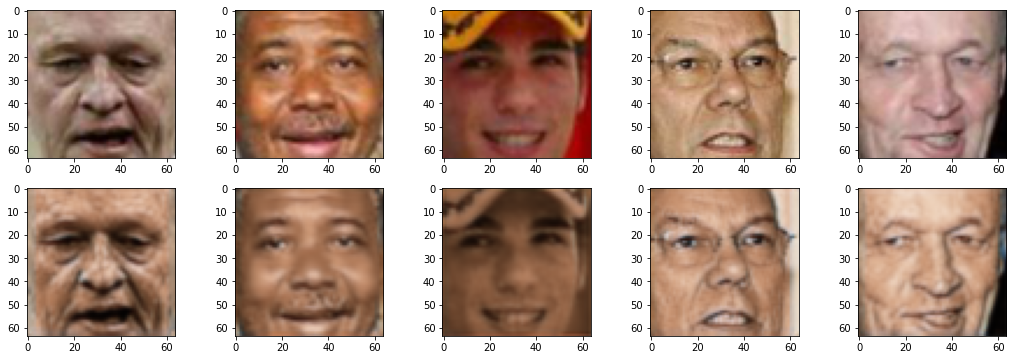

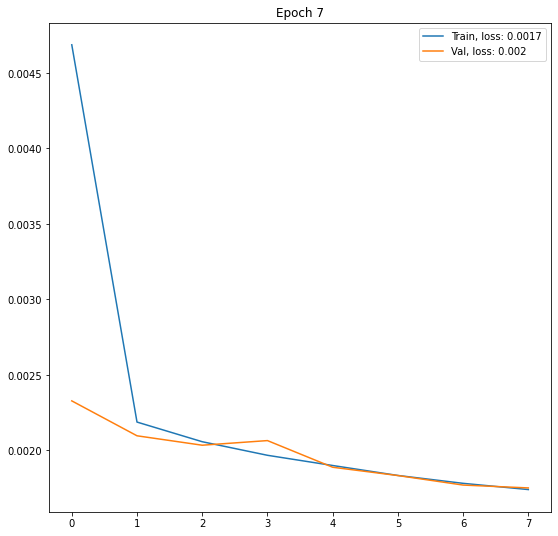

In [42]:
best_param, latent_code, train_losses, val_losses = train(data_val, data_tr, 8)

## 1.4. Sampling

Now let's not just take a picture, run it through the autoecoder and get a reconstruction, but try to create something NEW

Let's take and slip some vectors generated by us (for example, from a normal distribution) to the decoder and look at the result of the reconstruction of the decoder:

In [11]:
latent_code.size()

torch.Size([3, 1, 64, 64])

(25, 64, 64, 3)


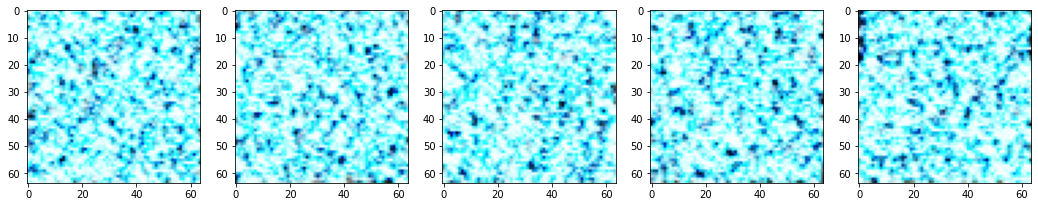

In [12]:
z = np.random.randn(25, 1, 64, 64)
z = torch.Tensor(z)
z = z.to(DEVICE)

autoencoder.eval()
with torch.no_grad():
    out = autoencoder.decode(z)
    out = out.cpu().detach().numpy()
    out = np.rollaxis(out,1,4)
print(out.shape)

plt.figure(figsize=(18,6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(out[i])
plt.show();

## Time to make fun!

Let's learn how to draw smiles on people =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

The plan is this:

1. You need to select the "smile vector": for this you need to find several (~ 15) people with smiles and the same number without from a sample of images.

The dataset description file downloaded with the dataset will help you find people with smiles. It contains the names of the pictures and the general attributes (smiles, glasses ...)

2. Calculate the latent vector for all smiling people (run them through the encoder) and the same for all sad people

3. Calculate, in fact, the smile vector - calculate the difference between the average latent vector of smiling people and the average latent vector of sad people

4. And now let's add a smile to a sad person: add the vector obtained in step 3 to the latent vector of a sad person and run the resulting vector through the decoder. Let's get the same person, but no longer sad!

In [44]:
N = 200

indices_largest = attrs['Smiling'].astype('float32').nlargest(N).index
indices_smallest = attrs['Smiling'].astype('float32').nsmallest(N).index

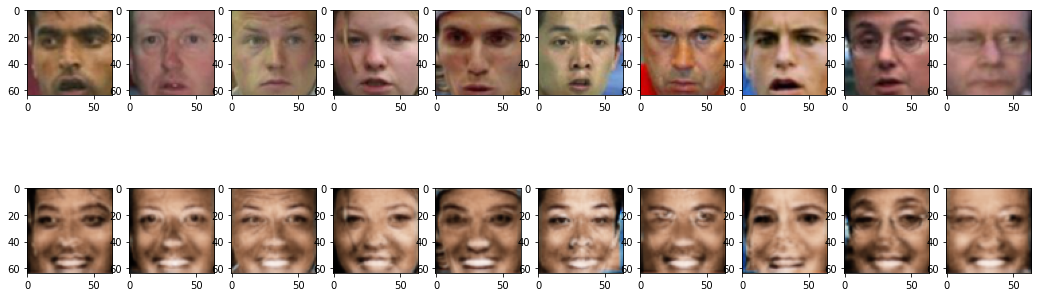

In [48]:
smiling_batch = DataLoader(np.rollaxis(X[indices_largest], 3, 1), batch_size=len(indices_largest), shuffle=False)
sad_batch = DataLoader(np.rollaxis(X[indices_smallest], 3, 1), batch_size=len(indices_largest), shuffle=False)

def get_latent_vector(my_batch):
    for batch in my_batch:
        batch = batch.to(DEVICE)
        autoencoder.eval()
        with torch.no_grad():
            latent_faces = autoencoder.encode(batch)
            latent_vector = latent_faces.mean(0)
    return latent_vector

smile_vector = get_latent_vector(smiling_batch) - get_latent_vector(sad_batch)

for batch in sad_batch:
    batch = batch.to(DEVICE)
    autoencoder.eval()
    with torch.no_grad():
        latent_faces_augmented = autoencoder.encode(batch) + 2*smile_vector
        sad_faces_augmented = autoencoder.decode(latent_faces_augmented)    
out = sad_faces_augmented.cpu().detach().numpy()
out = np.rollaxis(out,1,4)

plt.figure(figsize=(18,6))
num_img = 10
for i in range(num_img):
    plt.subplot(2, num_img, i+1)
    plt.imshow(X[indices_smallest][i])

    plt.subplot(2, num_img, num_img+i+1)
    plt.imshow(out[i])

plt.show();

# Part 2: Variational Autoencoder

Let's start training variational autoencoders - an upgraded version of AE. We will train on the MNIST dataset containing handwritten numbers from 0 to 9

In [15]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Model architecture and training

Lets implement VAE.

In [16]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        latent_dim = 25
        features = 28*28
        self.encoder_layer_1 = nn.Linear(features, features//2)
        self.encoder_layer_mu = nn.Linear(features//2, latent_dim)
        self.encoder_layer_logsigma = nn.Linear(features//2, latent_dim)
        self.decoder_layer_1 = nn.Linear(latent_dim, features//2)
        self.decoder_layer = nn.Linear(features//2, features)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        mu = self.encoder_layer_mu(x)
        mu = self.relu(mu)
        logsigma = self.encoder_layer_logsigma(x)
        logsigma = self.relu(logsigma)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            sample = torch.randn_like(mu) * torch.exp(logsigma / 2.0) + mu
            return sample
        else:
            return mu
    
    def decode(self, z):
        z = self.decoder_layer_1(z)
        z = self.relu(z)
        z = self.decoder_layer(z)
        reconstruction = self.sigmoid(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

VAE loss consists of two parts: KL and log-likelihood.

The total loss will look like this:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Formula for KL Divergence:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

As a log-likelihood, let's take the usual cross-entropy.

In [17]:
def KL_divergence(mu, logsigma):
    loss = -0.5*torch.sum(1.0 + logsigma - torch.square(mu) - torch.exp(logsigma))
    return loss

def log_likelihood(x, reconstruction):
    loss = torch.nn.BCELoss()
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return (KL_divergence(mu, logsigma)/28/28/256 + log_likelihood(x, reconstruction))

Model training

In [18]:
criterion = loss_vae
autoencoder = VAE().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

def predict_val(x, autoencoder):
    autoencoder.eval()
    with torch.no_grad():
        N_batch = x.shape[0]
        x = x.view(x.shape[0], -1)
        x = x.to(DEVICE)
        mu, logsigma, reconstruction = autoencoder(x)
        reconstruction = reconstruction.cpu().detach()
        reconstruction = torch.reshape(reconstruction, (N_batch, 1, 28, 28))

    return reconstruction

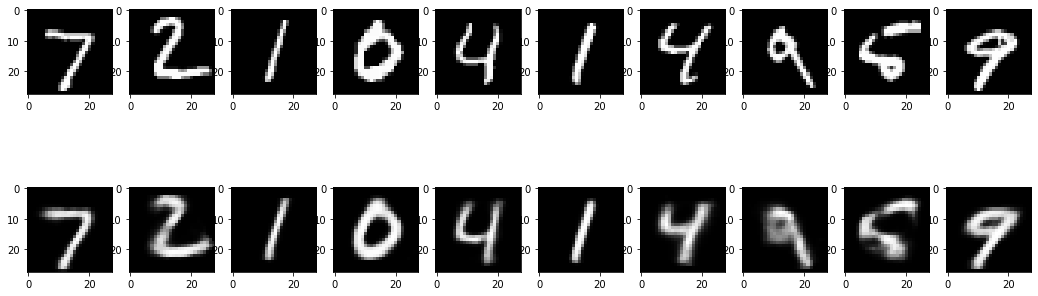

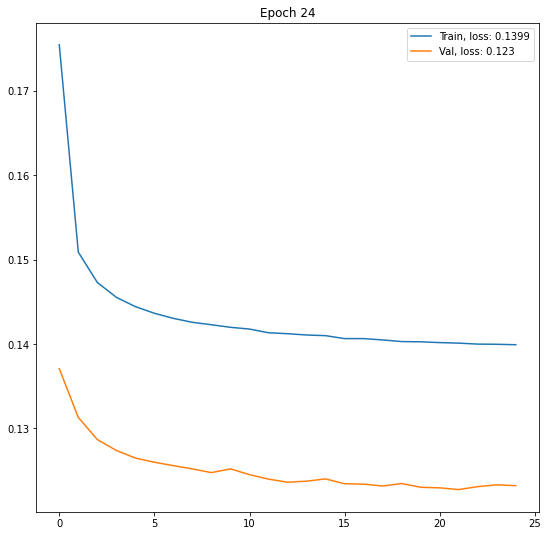

In [19]:
train_losses = []
val_losses = []
n = 10
idx = range(n)
epochs = 25
for epoch in range(epochs):
    print('* Epoch %d/%d' % (epoch, epochs))
    autoencoder.train()
    avg_loss=0
    for i, batch in enumerate(notebook.tqdm(train_loader)):
        X_batch, y_batch = batch
        N_batch = X_batch.shape[0]
        X_batch = X_batch.view(X_batch.shape[0], -1)
        X_batch = X_batch.to(DEVICE)
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(X_batch)
        loss = criterion(X_batch.detach(), mu, logsigma, reconstruction)
        avg_loss += loss / len(train_loader)
        loss.backward() 
        optimizer.step() 
    print(f'train loss {np.round(avg_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')
    train_loss = avg_loss
    train_losses.append(train_loss.cpu().detach().numpy())

    autoencoder.eval() 
    val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(notebook.tqdm(test_loader)):
            X_batch, y_batch = batch
            X_batch = X_batch.view(X_batch.shape[0], -1)
            X_batch = X_batch.to(DEVICE)
            mu, logsigma, reconstruction = autoencoder(X_batch)
            loss = criterion(X_batch.detach(), mu, logsigma, reconstruction)
            val_loss += loss / len(test_loader)
        print(f'val loss {np.round(val_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')
        val_losses.append(val_loss.cpu().detach().numpy())
    data_example = test_loader.dataset.test_data[idx]
    data_example = torch.unsqueeze(data_example, 1) / 255.
    x = predict_val(data_example, autoencoder)
    clear_output()
  
    plt.figure(figsize=(18,6))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(data_example[i].permute(1,2,0).flatten(1,-1),cmap='gray')
        plt.subplot(2, n, n+i+1)
        plt.imshow(x[i].permute(1,2,0).flatten(1,-1) * 255.,cmap='gray')
    fig = plt.figure(figsize=(9, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}')
    plt.plot(np.arange(len(val_losses)), val_losses, label=f'Val, loss: {val_loss:.3f}')
    plt.title(f'Epoch {epoch}')
    plt.legend(loc='best')
    plt.show()

Let's see how our trained VAE encodes and restores pictures: Let's see how our trained VAE encodes and restores pictures:

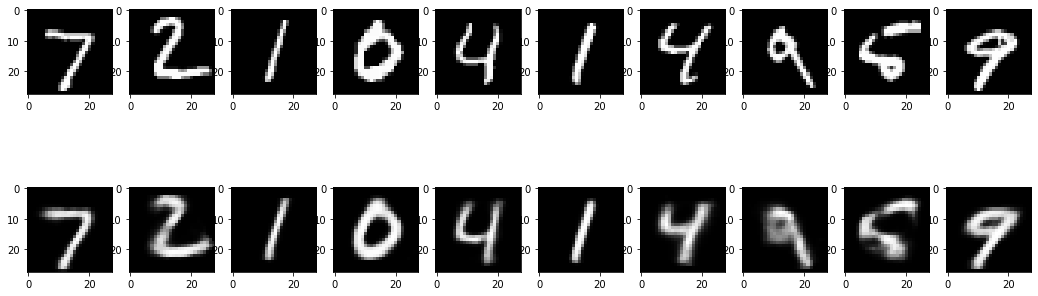

In [20]:
data_example = test_loader.dataset.test_data[idx]
data_example = torch.unsqueeze(data_example, 1) / 255.

x = predict_val(data_example, autoencoder)
clear_output()
plt.figure(figsize=(18,6))

for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(data_example[i].permute(1,2,0).flatten(1,-1),cmap='gray')
    plt.subplot(2, n, n+i+1)
    plt.imshow(x[i].permute(1,2,0).flatten(1,-1) * 255.,cmap='gray')
plt.show();

Let's try to do the same for VAE as with a regular autoencoder - slip random vectors from the normal distribution to the decoder from the VAE and see what pictures are obtained:

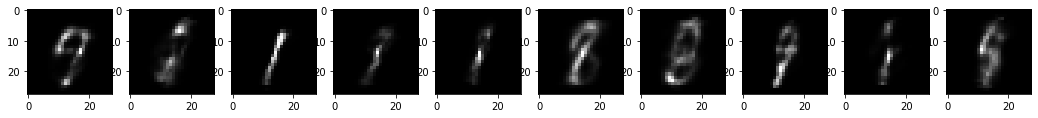

In [21]:
z = torch.randn((10, 1, 5, 5)).to(DEVICE)
N_batch = z.shape[0]
z = z.view(z.shape[0], -1)

autoencoder.eval()
with torch.no_grad():
    output = autoencoder.decode(z)
    output = output.cpu().detach()
output = torch.reshape(output, (N_batch, 1, 28, 28))

plt.figure(figsize=(18,6))
n  = 10
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(output[i].permute(1,2,0).flatten(1,-1),cmap='gray')
plt.show();

## 2.2. Latent Representation

Let's see how latent vectors of face pictures look in space.
Let's depict the latent vectors of pictures as points in two-dimensional space.

This will allow us to estimate how densely the latent vectors of digit images are distributed in space.

Plus, let's do this thing: paint the dots that correspond to the pictures of each number in their own separate color



So the plan is:
1. Get latent representations of pictures of the test dataset
2. With the help of `TSNE` (available in `sklearn`) compress these representations to a dimension of 2 (so that they can be visualized as points in space)
3. Visualize the resulting two-dimensional representations using `matplotlib.scatter`, color the points corresponding to pictures of different numbers with different colors.

In [22]:
N = 10000

data_example = test_loader.dataset.test_data[range(N)]
data_example = torch.unsqueeze(data_example, 1) / 255.
labels = test_loader.dataset.targets[range(N)]

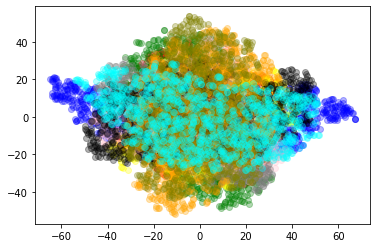

In [23]:
def select_number(num, data_example):
    f = labels == num
    torch.nonzero(f)
    filtered_tensor = data_example[f]
    return filtered_tensor

nums = list(range(10))
colors = ['red', 'blue', 'green', 'yellow', 'pink', 'gray', 'black', 'orange', 'olive', 'cyan']

def return_latent(x):
    autoencoder.eval()
    with torch.no_grad():
        N_batch = x.shape[0]
        x = x.view(x.shape[0], -1)
        x = x.to(DEVICE)
        mu, logsigma = autoencoder.encode(x)
        mu = mu.cpu().detach().numpy()
    return mu 

for i in range(len(nums)):
    nums[i] = select_number(nums[i], data_example)
    nums[i] = return_latent(nums[i])
    nums[i] = TSNE(n_components=2).fit_transform(nums[i])
    plt.scatter(nums[i][:,0], nums[i][:,1], c=colors[i], alpha=0.3)
plt.show()

The points are quite crowded, but the distribution along the x-axis is more elongated

## 2.3. Conditional VAE 


We have already learned how to train regular AE on a dataset of images and get new images using noise generation and a decoder.
Let's now assume that we trained AE on the MNIST dataset and now we want to generate new pictures with numbers using a decoder (as we generated random faces above).
And so we needed to generate the number 8, and we substitute different variants of noise, but the eight is not generated in any way :(

I would like to add to our AE the function "give me a random number from this class here", where there are ten classes (numbers from 0 to 9 form ten classes). Conditional AE is the name of the type of autoencoder that provides this capability. Well, the name "conditional" already speaks for itself.

### Architecture

The picture below shows the architecture of a simple Conditional VAE.

In fact, the only difference from the usual one is that, together with the picture in the first layer of the encoder and decoder, we also transmit information about the picture class.

That is, the concatenation of the picture and information about the class (for example, a vector of nine zeros and one one) is fed to the first (input) layer of the encoder. The first layer of the decoder is fed the concatenation of the latent vector and the class information.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



Thus, when generating a new random picture, we will have to pass the concatenated latent vector and picture class to the decoder.

In [24]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        condition_dim = 10
        latent_dim = 25
        features = 28*28
        self.encoder_layer_1 = nn.Linear(features + condition_dim, (features + condition_dim)//2)
        self.encoder_layer_3_mu = nn.Linear((features + condition_dim)//2, latent_dim)
        self.encoder_layer_3_logsigma = nn.Linear((features + condition_dim)//2, latent_dim)
        self.decoder_layer_1 = nn.Linear(latent_dim + condition_dim, (features + condition_dim)//2)
        self.decoder_layer_3 = nn.Linear((features + condition_dim)//2, features)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
  
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            sample = torch.randn_like(mu) * torch.exp(logsigma / 2.0) + mu
            return sample
        else:
            return mu

    def encode(self, x):
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        mu = self.encoder_layer_3_mu(x)
        mu = self.relu(mu)
        logsigma = self.encoder_layer_3_logsigma(x)
        logsigma = self.relu(logsigma)
        return mu, logsigma
    
    def decode(self, z):
        z = self.decoder_layer_1(z)
        z = self.relu(z)
        z = self.decoder_layer_3(z)
        reconstruction = self.sigmoid(z)
        return reconstruction

    def forward(self, x, y):
        mu, logsigma = self.encode(torch.cat((x, y), 1))
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(torch.cat((z, y), 1))
        return mu, logsigma, reconstruction

In [25]:
criterion = loss_vae
autoencoder = CVAE().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

In [26]:
def predict_val(x, labels, autoencoder):
    autoencoder.eval()
    with torch.no_grad():
        n_classes = 10
        N_batch = x.shape[0]
        x = x.view(x.shape[0], -1)
        x = x.to(DEVICE)
        y = torch.zeros(N_batch, n_classes)
        y[range(y.shape[0]), labels] = 1
        y = y.to(DEVICE)
        mu, logsigma, reconstruction = autoencoder(x, y)
        reconstruction = reconstruction.cpu().detach()
        reconstruction = torch.reshape(reconstruction, (N_batch, 1, 28, 28))
        return reconstruction

n = 10
idx = range(n)

data_example = test_loader.dataset.test_data[idx]
data_example = torch.unsqueeze(data_example, 1) / 255.
labels = test_loader.dataset.targets[range(n)]

C:\Users\amorf\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


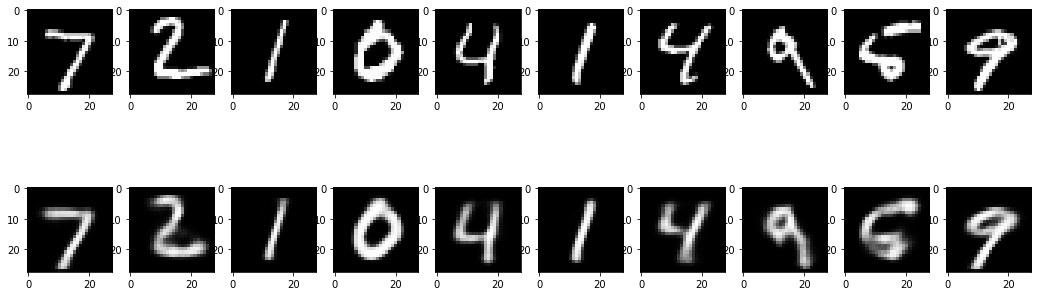

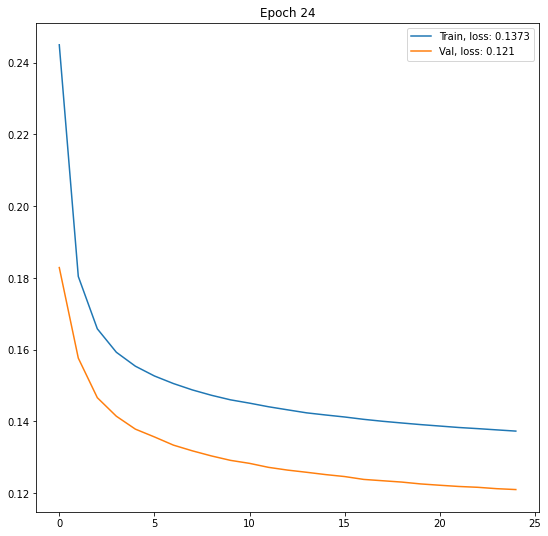

In [27]:
epochs = 25
n_classes=10

train_losses = []
val_losses = []

for epoch in range(epochs):
    print('* Epoch %d/%d' % (epoch, epochs))
    autoencoder.train()
    avg_loss=0
    for i, batch in enumerate(notebook.tqdm(train_loader)):
        X_batch, y_batch = batch
        N_batch = X_batch.shape[0]
        X_batch = X_batch.view(X_batch.shape[0], -1)
        X_batch = X_batch.to(DEVICE)
        y = torch.zeros(N_batch, n_classes)
        y[range(y.shape[0]), y_batch] = 1
        y = y.to(DEVICE)
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(X_batch, y)
        loss = criterion(X_batch.detach(), mu, logsigma, reconstruction)
        avg_loss += loss / len(train_loader)
        loss.backward() 
        optimizer.step()
    print(f'train loss {np.round(avg_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')
    train_loss = avg_loss
    train_losses.append(train_loss.cpu().detach().numpy())

    autoencoder.eval()  
    val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(notebook.tqdm(test_loader)):
            X_batch, y_batch = batch
            N_batch = X_batch.shape[0]
            X_batch = X_batch.view(X_batch.shape[0], -1)
            X_batch = X_batch.to(DEVICE)
            y = torch.zeros(N_batch, n_classes)
            y[range(y.shape[0]), y_batch] = 1
            y = y.to(DEVICE)
            mu, logsigma, reconstruction = autoencoder(X_batch, y)
            loss = criterion(X_batch.detach(), mu, logsigma, reconstruction)
            val_loss += loss / len(test_loader)
        print(f'val loss {np.round(val_loss.cpu().detach().numpy(), 5)}, epoch {epoch}')
        val_losses.append(val_loss.cpu().detach().numpy())
    x = predict_val(data_example, labels, autoencoder)
    clear_output()
    plt.figure(figsize=(18,6))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(data_example[i].permute(1,2,0).flatten(1,-1),cmap='gray')
        plt.subplot(2, n, n+i+1)
        plt.imshow(x[i].permute(1,2,0).flatten(1,-1) * 255.,cmap='gray')
    fig = plt.figure(figsize=(9, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}')
    plt.plot(np.arange(len(val_losses)), val_losses, label=f'Val, loss: {val_loss:.3f}')
    plt.title(f'Epoch {epoch}')
    plt.legend(loc='best')
    plt.show()

### Sampling


Here we will be sampling from CVAE. This is cooler than sampling from a simple AE/VAE: here you can take the same latent vector and ask CVAE to restore pictures of different classes from it!
For MNIST, you can ask CVAE to recover from a single latent vector, for example, pictures of the numbers 1 and 7.

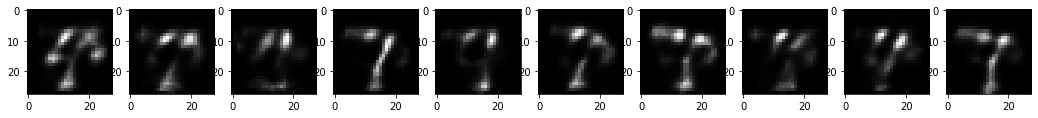

In [28]:
latent_dim = 25
z = torch.randn((10, 1, 5, 5)).to(DEVICE)
N_batch = z.shape[0]
z = z.view(z.shape[0], -1)
labels = [7]*N_batch

y = torch.zeros(N_batch, n_classes)
y[range(y.shape[0]), labels] = 1
y = y.to(DEVICE)

autoencoder.eval()
with torch.no_grad():
    output = autoencoder.decode(torch.cat((z, y), 1))
    output = output.cpu().detach()
output = torch.reshape(output, (N_batch, 1, 28, 28))

plt.figure(figsize=(18,6))
n  = 10
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(output[i].permute(1,2,0).flatten(1,-1),cmap='gray')
plt.show()

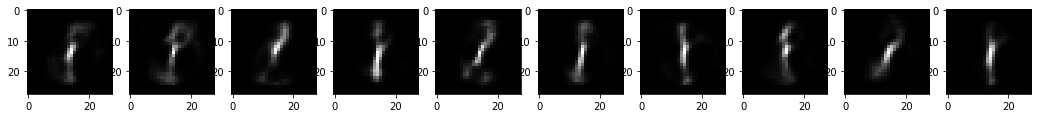

In [29]:
labels = [1]*N_batch
y = torch.zeros(N_batch, n_classes)
y[range(y.shape[0]), labels] = 1
y = y.to(DEVICE)
autoencoder.eval()
with torch.no_grad():
    output = autoencoder.decode(torch.cat((z, y), 1))
    output = output.cpu().detach()
output = torch.reshape(output, (N_batch, 1, 28, 28))

plt.figure(figsize=(18,6))
n  = 10
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(output[i].permute(1,2,0).flatten(1,-1),cmap='gray')
plt.show()

### Latent Representations

Let's see what the latent space of pictures looks like in CVAE and compare with the picture for VAE

Again, we need to paint the dots in different colors depending on the class.

C:\Users\amorf\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


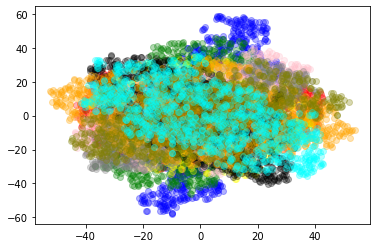

In [30]:
N = 10000

data_example = test_loader.dataset.test_data[range(N)]
data_example = torch.unsqueeze(data_example, 1) / 255.
labels = test_loader.dataset.targets[range(N)]

nums = list(range(10))

def return_latent(x, i):
    autoencoder.eval()
    with torch.no_grad():
        N_batch = x.shape[0]
        x = x.view(x.shape[0], -1)
        x = x.to(DEVICE)
        y_batch = [i] * N_batch
        y = torch.zeros(N_batch, n_classes)
        y[range(y.shape[0]), y_batch] = 1
        y = y.to(DEVICE)
        mu, logsigma = autoencoder.encode(torch.cat((x, y), 1))
        mu = torch.cat((mu, y), 1)
        mu = mu.cpu().detach().numpy()
    return mu 

for i in range(len(nums)):
    nums[i] = select_number(nums[i], data_example)
    nums[i] = return_latent(nums[i], i)
    nums[i] = TSNE(n_components=2).fit_transform(nums[i])
    plt.scatter(nums[i][:,0], nums[i][:,1], color=colors[i], alpha=0.3)
plt.show()

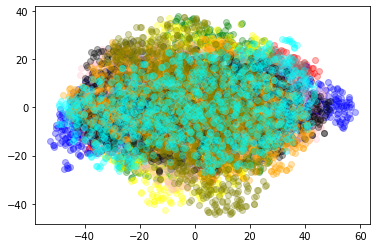

In [31]:
nums = list(range(10))

def return_latent(x, i):
    autoencoder.train()
    with torch.no_grad():
        N_batch = x.shape[0]
        x = x.view(x.shape[0], -1)
        x = x.to(DEVICE)
        y_batch = [i] * N_batch
        y = torch.zeros(N_batch, n_classes)
        y[range(y.shape[0]), y_batch] = 1
        y = y.to(DEVICE)
        mu, logsigma = autoencoder.encode(torch.cat((x, y), 1))
        z = autoencoder.gaussian_sampler(mu, logsigma)
        z = torch.cat((z, y), 1)
        z = z.cpu().detach().numpy()
    return z

for i in range(len(nums)):
    nums[i] = select_number(nums[i], data_example)
    nums[i] = return_latent(nums[i], i)
    nums[i] = TSNE(n_components=2, init='pca').fit_transform(nums[i])
    plt.scatter(nums[i][:,0], nums[i][:,1], color=colors[i], alpha=0.3)
plt.show()

Compared to the VAE, the points of the latent space of the CVAE are even more clustered and close to each other.